In [12]:
import json 
import pandas as pd 
import dateparser
import numpy as np
import sentry_helper as sh
from IPython.display import display, HTML
from pandas.io.json import json_normalize 

Start with downloading the events from Sentry.We get the 100 lates by:

`curl -H 'Authorization: Bearer <API KEY>' https://sentry.app.svt.se/api/0/issues/<id as number>/events/`

Then load the file with open(). If we check the returned value by `type(raw)` we learn that it is a `list`

In [13]:
with open('/Users/asapehrsson/dev/learn/notebook_sentry/failing_rich_push_events.json') as f:
    raw = json.load(f)

The raw object holds a nested dictionary. We want to flatten the object.  
TODO: fix the warning DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future

We also want to convert the date string to the (for pandas) useful type `pandas._libs.tslib.Timestamp`

In [14]:
data = sh.flatten_event(raw)

Now we normalize the list to get the wanted data type `pandas.core.frame.DataFrame`

`tail()` prints the last 5 posts in the data frame. Useful for an initial look at the data.

In [15]:
data.tail()

,arch,battery_level,brand,charging,created,family,free_memory,free_storage,low_memory,manufacturer,...,model_id,online,orientation,screen_density,screen_dpi,screen_resolution,simulator,storage_size,type,version
95,armeabi-v7a,72.0,samsung,False,2018-08-26 06:30:06,SM-G390F,741486592,8102653952,False,samsung,...,NRD90M,False,portrait,2.0,320,1280x720,False,12116492288,device,7.0
96,armeabi-v7a,97.0,samsung,False,2018-08-26 06:29:31,SM-J510FN,719900672,3774005248,False,samsung,...,NMF26X,False,portrait,2.0,320,1280x720,False,11932979200,device,7.1.1
97,arm64-v8a,100.0,Sony,False,2018-08-26 06:29:24,E6553,1357660160,1692168192,False,Sony,...,32.4.A.1.54,False,portrait,3.0,480,1776x1080,False,24240054272,device,7.1.1
98,arm64-v8a,99.0,samsung,False,2018-08-26 06:29:24,SM-G930F,1671630848,8480030720,False,samsung,...,R16NW,False,portrait,3.0,480,1920x1080,False,26659282944,device,8.0.0
99,armeabi-v7a,51.0,samsung,False,2018-08-26 06:29:16,SM-G900F,439799808,2903764992,False,samsung,...,MMB29M,False,portrait,3.0,480,1920x1080,False,12688674816,device,6.0.1


In [16]:
data.columns

Index(['arch', 'battery_level', 'brand', 'charging', 'created', 'family',
       'free_memory', 'free_storage', 'low_memory', 'manufacturer',
       'memory_size', 'model', 'model_id', 'online', 'orientation',
       'screen_density', 'screen_dpi', 'screen_resolution', 'simulator',
       'storage_size', 'type', 'version'],
      dtype='object')

The `online` index is the one that we want to investigate further. `type(data['online'][0])` reveales that it is a `numpy.bool_`

We check how many is true respective false

In [17]:
data['online'].value_counts()

False    93
True      7
Name: online, dtype: int64

In [18]:
data['screen_resolution'].value_counts()

1920x1080    33
1280x720     16
2076x1080    14
2560x1440     7
2094x1080     6
1776x1080     4
2154x1080     3
1920x1200     3
1794x1080     3
1184x720      3
1232x800      1
2220x1080     1
2952x1440     1
2048x1536     1
1812x1080     1
2034x1080     1
2016x1080     1
1824x1200     1
Name: screen_resolution, dtype: int64

In [19]:
data['orientation'].value_counts()

portrait     96
landscape     4
Name: orientation, dtype: int64

In [20]:

df = (data.loc[data['online'] == False]).drop(['brand', 'arch', 'free_memory', 'model', 
                                          'simulator', 'storage_size', 'charging',
                                        'memory_size', 'free_storage','family','model_id','type'], axis=1).sort_values(ascending=True, by='created')

display(HTML(df.to_html()))

,battery_level,created,low_memory,manufacturer,online,orientation,screen_density,screen_dpi,screen_resolution,version
99,51.000000,2018-08-26 06:29:16,False,samsung,False,portrait,3.000,480,1920x1080,6.0.1
98,99.000000,2018-08-26 06:29:24,False,samsung,False,portrait,3.000,480,1920x1080,8.0.0
97,100.000000,2018-08-26 06:29:24,False,Sony,False,portrait,3.000,480,1776x1080,7.1.1
96,97.000000,2018-08-26 06:29:31,False,samsung,False,portrait,2.000,320,1280x720,7.1.1
95,72.000000,2018-08-26 06:30:06,False,samsung,False,portrait,2.000,320,1280x720,7.0
94,96.000000,2018-08-26 06:30:43,False,samsung,False,portrait,2.625,420,2094x1080,8.0.0
93,61.000000,2018-08-26 06:30:45,False,OnePlus,False,portrait,2.625,420,2154x1080,8.1.0
92,42.000000,2018-08-26 06:31:09,False,samsung,False,portrait,3.000,480,2076x1080,8.0.0
91,92.000000,2018-08-26 06:31:28,False,samsung,False,portrait,2.000,320,1280x720,8.0.0
90,28.000000,2018-08-26 06:31:47,False,samsung,False,portrait,3.000,480,1920x1080,7.0


In [21]:
type(data['created'])

pandas.core.series.Series

We introduce a new column, `freq`, that just is a integer. Then we make 60 minutes bucket of out series, and present it!

In [22]:
data['freq']=np.where(data['online'] == False, 1, 0)

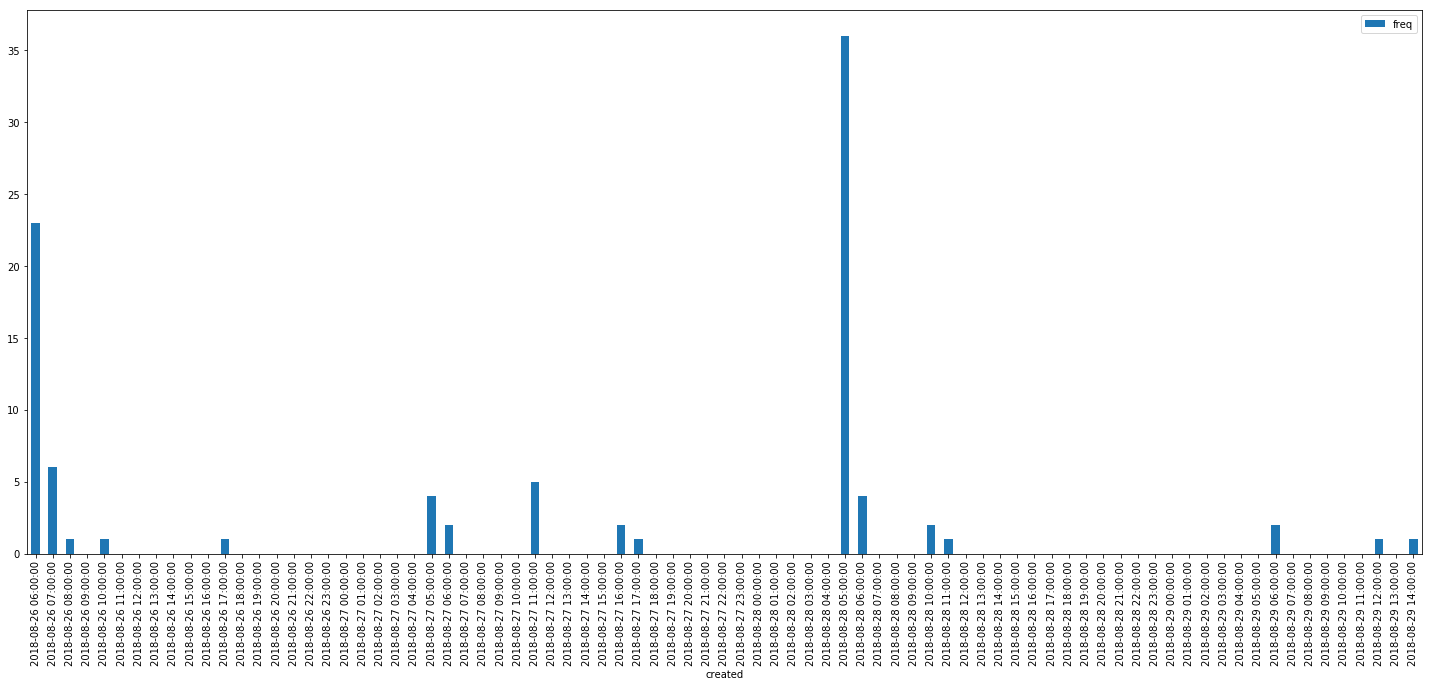

In [23]:
part = data[['created', 'freq']].copy()
part = part.set_index('created').resample('60Min').sum().plot(kind="bar", figsize=[25, 10])


In [24]:
data['manufacturer'].value_counts().sort_index()

HUAWEI       3
LENOVO       1
LGE          2
OnePlus      4
Sony         6
asus         1
motorola     2
samsung     81
Name: manufacturer, dtype: int64

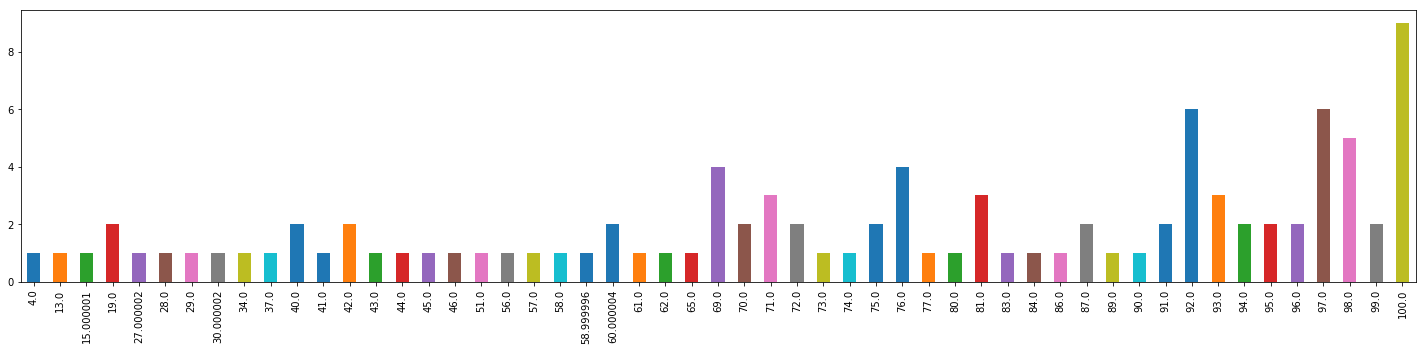

In [28]:
data['battery_level'].value_counts().sort_index().plot(kind='bar', figsize=[25, 5])

In [30]:
data['version'].value_counts().sort_index().plot(kind='bar', figsize=[25, 5])

6.0.1     5
7.0      21
7.1.1     9
8.0.0    60
8.1.0     5
Name: version, dtype: int64